# Time to get your hands dirty! Planning a telescope observation

Let’s build your first Markov Chain!

You are a real astronomer (not a theory guy like me) and are planning an expensive observational campaign. You want to know how likely it is that tomorrow night will be clear given the weather tonight (clear or cloudy). The key piece of information here is that the weather tomorrow depends on the weather today. From past history, you know that:

which means that

$$
P(\text{clear tomorrow} \mid \text{cloudy today}) = 0.5
$$

$$
P(\text{cloudy tomorrow} \mid \text{cloudy today}) = 0.5
$$

We also have

$$
P(\text{cloudy tomorrow} \mid \text{clear today}) = 0.1
$$

which means that

$$
P(\text{clear tomorrow} \mid \text{clear today}) = 0.9
$$


- We can start with the sky conditions today and make predictions going forward more and more into the future.  
  This will look like a big decision tree.
- After enough days, we’ll reach equilibrium probabilities that have to do with the mean weather statistics (ignoring seasons) and we’ll arrive at:

$$
P(\text{clear}) = 0.83
$$

$$
P(\text{cloudy}) = 0.17
$$

You get the same answer for day \( N \) as day \( N + 1 \), and it doesn’t matter whether it was clear or cloudy on the day that you started. The steps that we have taken in this process are, indeed, a **MARKOV CHAIN**.


## Tasks

- Start off on a cloudy day.
- Implement your weather forecast based on the above probabilities.
- Run your simulation for 
  $$
  N \text{ days (with } N \geq 10^5 \text{)}
  $$
- Prepare a plot with the number of days on the x-axis and the cumulative fraction of, say, sunny days over the number of days so far on the y-axis. This is called a **trace-plot**, showing how our estimate of 
  $$
  P(\text{clear})
  $$
  evolves as the chain samples.
- Prepare a histogram of the above plot. This reveals the distribution of 
  $$
  P(\text{clear})
  $$
- Use a summary statistic to determine the most likely value and an error on our estimate.


## Important

In MCMC the process must be **stationary**, which basically means that the chain statistics look the same no matter which chunk you look at (e.g., first half, second half, or any other point, etc.)

This means that we are **not** going to get to the true value in the early steps of the chain. In our example above, after some time the process was stationary, but not in the first few days.

So there is a **burn-in** phase that needs to be discarded. How we determine the number of early steps to discard as burn-in is tricky, but you should always start with a traceplot of your samples!



In the above example, experiment with chopping off different numbers of initial points as burn-in.



## (Optional, not essential)

- Read the intro to Markovian Finance  
  (see the note for the Markovian process describing the stock market in this notebook. If you’ve written your code well, this should require only minor modifications.)





In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import astroML.stats

In [2]:
N=10000 #number of days
weather=0 # 0 = rainy, 1 = sunny 
Prr=0.5 #rainy today->rainy tomorrow
Prs=0.5 #rainy today-> sunny tomorrow
Psr=0.1 #sunny today->rainy tomorrow
Pss=0.9 #sunny today->sunny tomorrow
Rainy=0 
Sunny=0
Ps=0 #Probability sunny
Pr=0 #Probaility rainy
days=[]

In [4]:
# Simulate Markov chain for N days
for i in range(N):
    num=np.random.uniform(0,1)
    if(weather==0): # Current day is Rainy
        if(num<Prr): # Stay Rainy
            Rainy+=1
            days.append(0)
            # weather remains 0 (Rainy)
        else: # Transition to Sunny
            Sunny+=1
            weather=1
            days.append(1)
    else: # Current day is Sunny
        if(num<Psr):  # Transition to Rainy
            Rainy+=1
            weather=0
            days.append(0)
        else: # Stay Sunny
            Sunny+=1
            days.append(1)
             # weather remains 1 (Sunny)
    
# Estimate probabilities  
Ps=Sunny/N
Pr=Rainy/N
print("The probability of Rainy days is:", Pr)
print("The probability of Sunny days is:", Ps)

The probability of Rainy days is: 0.1666
The probability of Sunny days is: 0.8334


In [8]:
# This function calculates the empirical probabilities of Rainy and Sunny days 
# over the first d days by counting occurrences in the 'days' list and dividing by d.
def cumulative_frequencies(d,days):
    r=0
    s=0
    for i in range(d):
        if days[i]==0:
            r+=1
        if days[i]==1:
            s+=1
    
    return r/d, s/d  


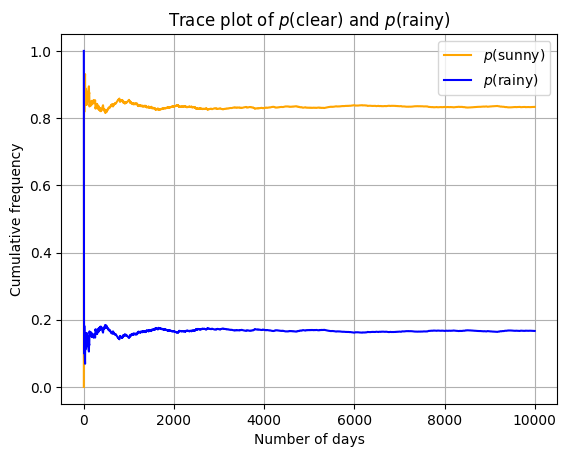

In [ ]:
sunny_days = []
rainy_days = []
# Loop over the days and compute the empirical probabilities up to each day
for i in range(1, N + 1):
    cdf_rainy, cdf_sunny = cumulative_frequencies(i, days)
    rainy_days.append(cdf_rainy)
    sunny_days.append(cdf_sunny)

# Plotting the comulative frequency over time
plt.plot(range(1, N + 1), sunny_days, label=r"$p(\mathrm{sunny})$", color='orange')
plt.plot(range(1, N + 1), rainy_days, label=r"$p(\mathrm{rainy})$", color='blue')
plt.xlabel("Number of days")
plt.ylabel("Cumulative frequency")
plt.title(r"Trace plot of $p(\mathrm{clear})$ and $p(\mathrm{rainy})$")
plt.legend()
plt.grid(True)
plt.show()

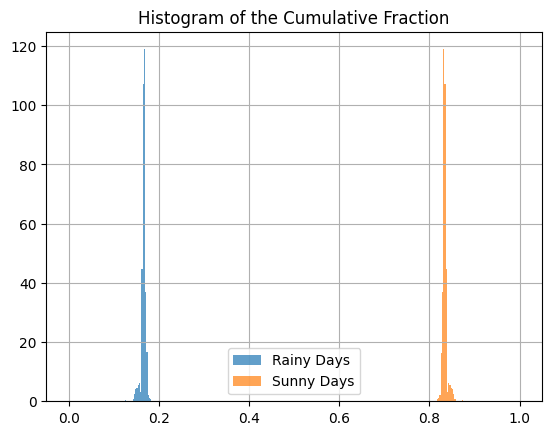

In [ ]:
# Plot histograms of the cumulative fractions for rainy and sunny days
# rainy_days and sunny_days contain the fraction of days classified as rainy or sunny up to each day
plt.hist(rainy_days, bins=int(len(rainy_days)/30), alpha=0.7, label="Rainy Days", density=True)
plt.hist(sunny_days, bins=int(len(sunny_days)/30), alpha=0.7, label="Sunny Days", density=True)
plt.title('Histogram of the Cumulative Fraction')
plt.grid(True)
plt.legend()
plt.show()

In [11]:
# Calculate the mean fraction of sunny days
mean_sunny_fraction = np.mean(sunny_days)
# Calculate the standard deviation of the sunny days fraction
std_sunny_fraction = np.std(sunny_days)
mean_rainy_fraction = np.mean(rainy_days)
std_rainy_fraction = np.std(rainy_days)

print(f"Sunny probability: {mean_sunny_fraction:.4f} ± {std_sunny_fraction:.4f}")
print(f"Rainy probability: {mean_rainy_fraction:.4f} ± {std_rainy_fraction:.4f}")

Sunny probability: 0.8341 ± 0.0113
Rainy probability: 0.1659 ± 0.0113


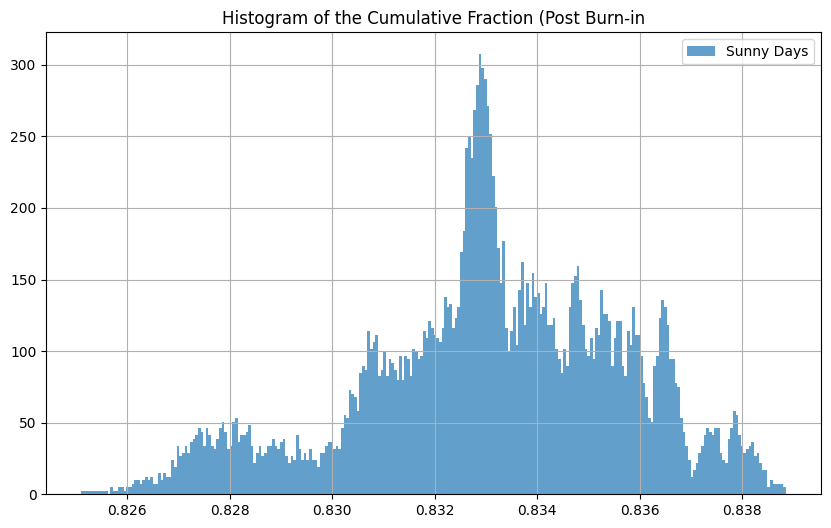

In [12]:
# Define the number of initial samples to discard as burn-in period
burn_in=2000
s_burnin=sunny_days[burn_in:]

plt.figure(figsize=(10, 6))
# Plot histogram of the sunny days fraction after burn-in
plt.hist(s_burnin,int(len(s_burnin)/30), alpha=0.7, label="Sunny Days", density=True)

plt.title('Histogram of the Cumulative Fraction (Post Burn-in')
plt.grid(True)
plt.legend()
plt.show()

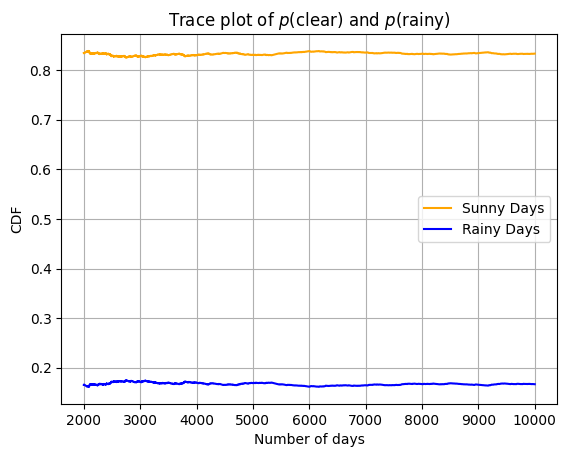

In [13]:
burn_in=2000
s_burnin=sunny_days[burn_in:]
r_burnin=rainy_days[burn_in:]


# Plot the fraction of sunny days and rainy days over time after burn-in
plt.plot(range(burn_in,N), s_burnin, label="Sunny Days", color="orange")
plt.plot(range(burn_in,N), r_burnin, label="Rainy Days", color="blue")

plt.xlabel("Number of days")
plt.ylabel("CDF")
plt.title(r"Trace plot of $p(\mathrm{clear})$ and $p(\mathrm{rainy})$")
plt.legend()
plt.grid(True)
plt.show()
